# Train the model

In [1]:
# Training Parameters
epochs = 10
learning_rate = 0.001

In [2]:
# Define the scheduled sampling function (Sigmoid decay curve)
def sigmoid_decay(x, x_mid, x_max, start_scheduled_sampling_epoch):
    # Sigmoid function with scaling and shifting
    return 1 / (1 + np.exp(-(x - start_scheduled_sampling_epoch - x_mid) / (k * (x_max - x_mid))))

# Parameters
x_mid = round(epochs * 0.55) # shift=0.5 converges f(midpoint) = 0.5; shifts scheduled_sampling_ratio curve further/closer from end of dataset
start_scheduled_sampling_epoch = round(epochs * 0.2) # Adjust this value to start scheduled sampling after a certain epoch
k = 0.3

In [3]:
"""
Demonstrating how to use the transformer model with time-series data.
This code includes a full training loop with scheduled sampling and an evaluation step.
"""

import dataset as ds
import utils
from torch.utils.data import DataLoader
import torch
import datetime
import transformer_timeseries as tst
import numpy as np

# Hyperparameters
test_size = 0.1
batch_size = 128
target_col_name = "FCR_N_PriceEUR"
timestamp_col = "timestamp"
cutoff_date = datetime.datetime(2017, 1, 1)

# Model Parameters
dim_val = 512
n_heads = 8
n_decoder_layers = 4
n_encoder_layers = 4
dec_seq_len = 92
enc_seq_len = 153
output_sequence_length = 48
window_size = enc_seq_len + output_sequence_length
step_size = 1
in_features_encoder_linear_layer = 2048
in_features_decoder_linear_layer = 2048
max_seq_len = enc_seq_len
batch_first = False
num_predicted_features = 1

# Define input variables
exogenous_vars = []
input_variables = [target_col_name] + exogenous_vars
target_idx = 0
input_size = len(input_variables)

# Read data
data = utils.read_data('dfs_merged_upload')

# Split data into training and test sets
split_idx = round(len(data) * (1 - test_size))
training_data_raw = data[:split_idx]
test_data_raw = data[split_idx:]

# Get training indices
training_indices = utils.get_indices_entire_sequence(
    data=training_data_raw,
    window_size=window_size,
    step_size=step_size)

# Get test indices
test_indices = utils.get_indices_entire_sequence(
    data=test_data_raw,
    window_size=window_size,
    step_size=step_size)

# Create custom dataset class for training data
training_data = ds.TransformerDataset(
    data=torch.tensor(training_data_raw[input_variables].values).float(),
    indices=training_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length)

# Create custom dataset class for test data
test_data = ds.TransformerDataset(
    data=torch.tensor(test_data_raw[input_variables].values).float(),
    indices=test_indices,
    enc_seq_len=enc_seq_len,
    dec_seq_len=dec_seq_len,
    target_seq_len=output_sequence_length)

# Create DataLoader for training data
training_dataloader = DataLoader(training_data, batch_size)

# Create DataLoader for test data
test_dataloader = DataLoader(test_data, batch_size)

# Initialize model
model = tst.TimeSeriesTransformer(
    input_size=len(input_variables),
    dec_seq_len=enc_seq_len,
    batch_first=batch_first,
    num_predicted_features=num_predicted_features,
    dim_val=dim_val
)

# Define loss function and optimizer
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_history = []

# Training loop
for epoch in range(epochs):
    if epoch >= start_scheduled_sampling_epoch:
        scheduled_sampling_ratio = sigmoid_decay(epoch, x_mid, epochs, start_scheduled_sampling_epoch)
    else:
        scheduled_sampling_ratio = 0.0  # Use teacher-forcing before start_scheduled_sampling_epoch
   
    for i, batch in enumerate(training_dataloader):
        src, trg, trg_y = batch

        # Scheduled sampling
        if scheduled_sampling_ratio > np.random.rand():
            trg = trg_y.unsqueeze(-num_predicted_features)  # Add a singleton dimension for the features

        # Permute shape if needed
        if not batch_first:
            src = src.permute(1, 0, 2)
            trg = trg.permute(1, 0, 2)

        # Generate masks
        src_mask = utils.generate_square_subsequent_mask(dim1=output_sequence_length, dim2=enc_seq_len)
        tgt_mask = utils.generate_square_subsequent_mask(dim1=output_sequence_length, dim2=output_sequence_length)

        # Forward pass
        output = model(src=src, tgt=trg, src_mask=src_mask, tgt_mask=tgt_mask)

        # Compute loss
        loss = loss_function(output, trg_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()} Scheduled Sampling Ratio: {scheduled_sampling_ratio}")

Reading file in data/dfs_merged_upload.csv
From get_src_trg: data size = torch.Size([234, 1])
From get_src_trg: data size = torch.Size([26, 1])


/Users/ryneschroder/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([33, 48])) that is different to the input size (torch.Size([48, 33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Batch: 0, Loss: 877.6829833984375 Scheduled Sampling Ratio: 0.0
Epoch: 1, Batch: 0, Loss: 479.2082824707031 Scheduled Sampling Ratio: 0.0
Epoch: 2, Batch: 0, Loss: 420.7877197265625 Scheduled Sampling Ratio: 0.0066928509242848554
Epoch: 3, Batch: 0, Loss: 409.0513000488281 Scheduled Sampling Ratio: 0.015267153880374444
Epoch: 4, Batch: 0, Loss: 401.0177917480469 Scheduled Sampling Ratio: 0.03444519566621117
Epoch: 5, Batch: 0, Loss: 391.8951110839844 Scheduled Sampling Ratio: 0.07585818002124355
Epoch: 6, Batch: 0, Loss: 382.0094909667969 Scheduled Sampling Ratio: 0.15886910488091516
Epoch: 7, Batch: 0, Loss: 372.306884765625 Scheduled Sampling Ratio: 0.3029407160345927
Epoch: 8, Batch: 0, Loss: 362.7332458496094 Scheduled Sampling Ratio: 0.5
Epoch: 9, Batch: 0, Loss: 353.3635559082031 Scheduled Sampling Ratio: 0.6970592839654074


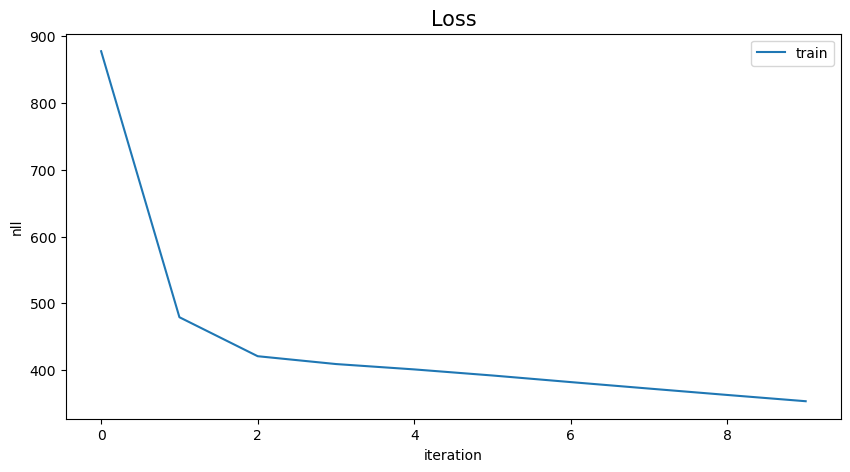

In [4]:
import matplotlib.pyplot as plt

# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

# Evaluate the model

In [5]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

In [6]:
forecasts_[0].shape

In [ ]:
forecasts = np.vstack(forecasts_)
print(forecasts.shape)

In [ ]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_data):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])
    
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")